In [2]:
!git clone https://github.com/iMohammad97/anomaly_detection

Cloning into 'anomaly_detection'...
remote: Enumerating objects: 4281, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 4281 (delta 41), reused 84 (delta 29), pack-reused 4177 (from 6)
Receiving objects: 100% (4281/4281), 362.37 MiB | 24.59 MiB/s, done.
Resolving deltas: 100% (1767/1767), done.
Updating files: 100% (3024/3024), done.


In [3]:
import os
import glob
import re
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# 1) Set your base directory.
base_directory = "/content/anomaly_detection/Experiments/Task4_5/Results"

# 2) The known time-series IDs (as given in the prompt).
time_series_ids = ["2", "37", "45", "23", "43", "21", "4", "8", "11", "20", "50", "51", "69", "31", "6"]

# Helper regex to parse folder names of the form: Anomaly_Task4_AE_Transformer_MSE
folder_pattern = re.compile(r'^Anomaly_Task(\d+)_(\w+)_(\w+)_(\w+)$')

# 3) We'll create a list to collect rows for one big DataFrame.
rows = []

# Go through each folder in base_directory
for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if not os.path.isdir(folder_path):
        continue  # skip non-directory

    # Parse folder name if it matches pattern:
    match = folder_pattern.match(folder_name)
    if not match:
        # Possibly the folder might have a different naming scheme, so skip or handle differently
        # For now, skip if it doesn't match the four-part pattern
        continue

    # Extract from folder name:
    task_num     = match.group(1)  # e.g., "4"
    model        = match.group(2)  # e.g., "AE", "SAE", etc.
    architecture = match.group(3)  # e.g., "Transformer", "LSTM", ...
    loss_func    = match.group(4)  # e.g., "MSE", "MaxDiff", ...

    # 4) Inside each folder, find all CSV result files matching pattern "*_results_ep200_ts{time-serie}.csv"
    #    or more generally, "*_results*ts*.csv"
    csv_files = sorted(glob.glob(os.path.join(folder_path, "*_results*_ts*.csv")))

    for csv_path in csv_files:
        csv_name = os.path.basename(csv_path)

        # Extract time-series ID from the filename with a simple regex or split:
        # We expect something like: "lstm_sae_results_ep200_ts45.csv"
        ts_id_match = re.search(r'_ts(\d+)\.csv$', csv_name)
        if not ts_id_match:
            # If we can't parse a time-series ID, skip or handle differently
            continue
        ts_id = ts_id_match.group(1)
        if ts_id not in time_series_ids:
            # Not in our known list, skip or continue if you want to keep everything
            continue

        # Read CSV to get metrics (AUC_Custom, AUC_PR, AUC_ROC, CompositeF1, etc.)
        df_csv = pd.read_csv(csv_path)
        # Typically, we expect columns like:
        #   ModelPath, AUC_Custom, PerfectPointFound, AUC_PR, AUC_ROC, CompositeF1
        # You can check or rename as needed.
        # Usually there's exactly one row, so we'll extract that row’s data:
        if df_csv.empty:
            continue
        row_data = df_csv.iloc[0].to_dict()

        # Insert extra columns: folder name, time-series ID, parsed fields
        row_data["FolderName"]   = folder_name
        row_data["Task"]         = task_num
        row_data["Model"]        = model
        row_data["Architecture"] = architecture
        row_data["LossFunction"] = loss_func
        row_data["TimeSeriesID"] = ts_id

        # Accumulate
        rows.append(row_data)

# 5) Build one big DataFrame
all_results_df = pd.DataFrame(rows)

if all_results_df.empty:
    print("No CSV data found. Check your directory paths and patterns.")
else:
    print("Collected results:")
    display(all_results_df.head(10))

    # 6) Compute average metrics for each folder (or for each combination of
    #    Task, Model, Architecture, LossFunction).
    metrics = ["AUC_Custom", "AUC_PR", "AUC_ROC", "CompositeF1"]  # or any columns you want
    group_cols = ["FolderName", "Task", "Model", "Architecture", "LossFunction"]

    # Group by your folder or by (Task, Model, Architecture, LossFunction)
    avg_metrics = (
        all_results_df
        .groupby(group_cols)[metrics]
        .mean()
        .reset_index()
    )

    print("\nAverage metrics per Folder:")
    display(avg_metrics)

    # 7) Quick Comparison Chart of Averages with Plotly
    #    For example, let's do a bar chart of CompositeF1 by FolderName
    fig_bar = px.bar(
        avg_metrics,
        x="FolderName",
        y="CompositeF1",
        color="LossFunction",
        hover_data=metrics,
        title="Comparison of CompositeF1 by Folder",
        height=600
    )
    fig_bar.update_xaxes(type='category')
    fig_bar.show()

    # 8) Make an interactive Plotly figure with filters (dropdowns)
    #    We'll create a single scatter plot with multiple metrics on the y-axis,
    #    and provide an updatemenu to filter by e.g. Task, Model, Architecture, LossFunction, TimeSeriesID.
    #    This is a demonstration of how to set up interactive filtering in a single figure.
    #    For more advanced usage, consider Plotly Dash or ipywidgets.

    # We'll create a base figure with all data points, then define "visible" states
    # in each dropdown selection. We'll let the user filter by:
    #   - 'Task'
    #   - 'Model'
    #   - 'Architecture'
    #   - 'LossFunction'
    #   - 'TimeSeriesID'
    # For each combination, we can hide/show data. This can get big quickly if
    # there are many combinations, so let's illustrate just one dimension or two.
    # For more complex usage, a Dash app is recommended.

    # For demonstration, let's filter by Task in one dropdown, and by Model in another.

    # Create a scatter figure of e.g. AUC_ROC vs AUC_PR, color by FolderName
    fig_scatter = px.scatter(
        all_results_df,
        x="AUC_PR",
        y="AUC_ROC",
        color="FolderName",
        hover_data=["TimeSeriesID", "Model", "Architecture", "LossFunction"],
        title="Interactive Filtering Example: PR vs ROC",
        height=600
    )

    # Build lists of unique tasks & models
    unique_tasks = sorted(all_results_df["Task"].unique())
    unique_models = sorted(all_results_df["Model"].unique())

    # We'll define an "all tasks" option
    dropdown_buttons_task = [
        dict(
            label="All Tasks",
            method="update",
            args=[{"visible": [True] * len(fig_scatter.data)}]  # show all
        )
    ]
    # For each task, show only points with that Task
    for task in unique_tasks:
        dropdown_buttons_task.append(
            dict(
                label=f"Task {task}",
                method="update",
                # We create a boolean mask for each data trace. But in px.scatter,
                # we have 1 trace per "FolderName" by default.
                # We can re-color by 'Task' or do a custom approach.
                args=[{
                    "visible": [
                        # We want to show this trace only if the underlying
                        # trace has data with the correct Task.
                        # Because px.scatter lumps all data of 'FolderName' in one trace,
                        # it's not trivial to filter within the same trace.
                        # A more direct approach is to recreate the figure on change
                        # or use dash.
                        # For demonstration, let's show/hide entire FolderName
                        # if it contains that Task at all:

                        bool(task in trace.name) or (trace.name == task)
                        for trace in fig_scatter.data
                    ]
                }]
            )
        )

    # Similarly for model:
    dropdown_buttons_model = [
        dict(
            label="All Models",
            method="update",
            args=[{"visible": [True] * len(fig_scatter.data)}]
        )
    ]
    for m in unique_models:
        dropdown_buttons_model.append(
            dict(
                label=m,
                method="update",
                args=[{
                    "visible": [
                        bool(m in trace.name)
                        for trace in fig_scatter.data
                    ]
                }]
        ))

    # We'll add 2 dropdowns. In practice, because the data are grouped by color=FolderName,
    # fully separate filtering for multiple columns in the same figure is quite tricky.
    # If you need multi-column filtering, consider a Plotly Dash or ipywidgets approach.
    fig_scatter.update_layout(
        updatemenus=[
            dict(
                x=0.0, y=1.15,
                xanchor='left', yanchor='top',
                buttons=dropdown_buttons_task,
                showactive=True,
                # name or direction is optional
            ),
            dict(
                x=0.25, y=1.15,
                xanchor='left', yanchor='top',
                buttons=dropdown_buttons_model,
                showactive=True,
            )
        ]
    )

    fig_scatter.show()


Collected results:


,ModelPath,AUC_Custom,PerfectPointFound,AUC_PR,AUC_ROC,CompositeF1,FolderName,Task,Model,Architecture,LossFunction,TimeSeriesID
0,/kaggle/working/results/transformer_ae_model_e...,0.035714,False,0.077709,0.448650,0.546584,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,11
1,/kaggle/working/results/transformer_ae_model_e...,0.000290,False,0.008228,0.591896,0.000000,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,2
2,/kaggle/working/results/transformer_ae_model_e...,0.003546,False,0.034500,0.484499,0.000000,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,20
3,/kaggle/working/results/transformer_ae_model_e...,0.000332,False,0.004120,0.254043,0.000000,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,21
4,/kaggle/working/results/transformer_ae_model_e...,0.006024,False,0.013226,0.370097,0.000000,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,23
5,/kaggle/working/results/transformer_ae_model_e...,0.001111,False,0.026894,0.399648,0.000000,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,31
6,/kaggle/working/results/transformer_ae_model_e...,0.000000,True,0.279854,0.722398,0.078775,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,37
7,/kaggle/working/results/transformer_ae_model_e...,0.000000,True,0.125589,0.683197,0.603774,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,4
8,/kaggle/working/results/transformer_ae_model_e...,0.000000,True,0.075017,0.496419,0.075269,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,43
9,/kaggle/working/results/transformer_ae_model_e...,0.000114,False,0.017309,0.396538,0.000000,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,45



Average metrics per Folder:


,FolderName,Task,Model,Architecture,LossFunction,AUC_Custom,AUC_PR,AUC_ROC,CompositeF1
0,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,0.028376,0.491625,0.772864,0.244561
1,Anomaly_Task4_AE_LSTM_MaxDiff,4,AE,LSTM,MaxDiff,0.005759,0.444151,0.705583,0.025709
2,Anomaly_Task4_AE_Transformer_MSE,4,AE,Transformer,MSE,0.002694,0.043480,0.580574,0.051495
3,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,0.010684,0.048211,0.518567,0.092574
4,Anomaly_Task5_SAE_LSTM_MSE,5,SAE,LSTM,MSE,0.026265,0.287246,0.761583,0.189922


<ipython-input-6-e4d9b55c68f3>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




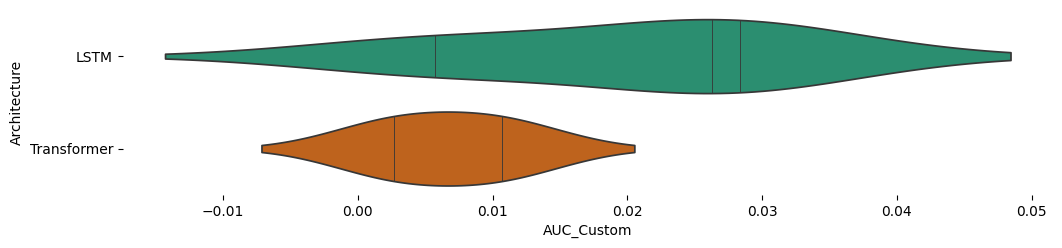

In [6]:
# @title Architecture vs AUC_Custom

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Architecture'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='AUC_Custom', y='Architecture', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

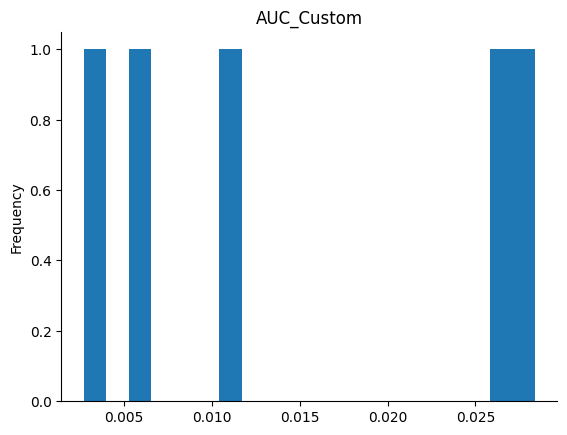

In [4]:
# @title AUC_Custom

from matplotlib import pyplot as plt
avg_metrics['AUC_Custom'].plot(kind='hist', bins=20, title='AUC_Custom')
plt.gca().spines[['top', 'right',]].set_visible(False)